In [89]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders import TargetEncoder


fifa = pd.read_csv('../data/raw/FIFA_players_21.csv')


In [90]:
# Aici am dat drop la coloanele irelevante

fifa = fifa.drop(columns=['defending_marking','loaned_from','real_face','nation_jersey_number','nation_position','player_tags','player_traits','joined','player_url','long_name','body_type','work_rate'])
print(fifa.columns.tolist())

['sofifa_id', 'short_name', 'age', 'dob', 'height_cm', 'weight_kg', 'nationality', 'club_name', 'league_name', 'league_rank', 'overall', 'potential', 'value_eur', 'wage_eur', 'player_positions', 'preferred_foot', 'international_reputation', 'weak_foot', 'skill_moves', 'release_clause_eur', 'team_position', 'team_jersey_number', 'contract_valid_until', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed', 'gk_positioning', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_posi

Aici am inceput parete de curatare si am incerput sa curat outliers valori eronate si valori lispa

In [91]:
fifa['release_clause_eur'] = np.where(fifa['release_clause_eur'].isnull,fifa['value_eur']*1.8,fifa['release_clause_eur']) 
fifa['release_clause_eur'].head(180)
fifa['release_clause_eur']=np.log1p(fifa['release_clause_eur']).round(5)
fifa['release_clause_eur'].tail()


18939    11.18444
18940    11.05091
18941    11.05091
18942    11.18444
18943    10.89676
Name: release_clause_eur, dtype: float64

In [92]:
fifa['value_eur'] = np.log1p(fifa['value_eur']).round(5)
fifa=fifa[fifa['value_eur'] != 0]
fifa['value_eur'].head(900)

0      18.02764
1      17.64415
2      18.13300
3      18.19754
4      18.31532
         ...   
916    16.38046
917    16.25786
918    16.34124
919    16.34124
920    16.25786
Name: value_eur, Length: 900, dtype: float64

In [93]:
fifa['dob'] = pd.to_datetime(fifa['dob'], format='%m/%d/%Y', errors='coerce')

Aici imi incepe partea de encoding si am facut encoding folosind Target encoding pe cele mari de ordinul miilor si one hot encoding pe cele mici cu 1-2 valori

In [94]:
# TargetEncoding

encoder=TargetEncoder(cols=['club_name'],smoothing=0.3)
fifa['club_name']=encoder.fit_transform(fifa[['club_name']],fifa['overall'])

In [95]:
encoder=TargetEncoder(cols=['nationality'],smoothing=0.3)
fifa['nationality']=encoder.fit_transform(fifa[['nationality']],fifa['overall'])

In [96]:
encoder=TargetEncoder(cols=['league_name'],smoothing=0.3)
fifa['league_name']=encoder.fit_transform(fifa[['league_name']],fifa['overall'])

In [97]:
# TargetEncoding

fifa['player_position_copy'] = fifa['player_positions'].copy()

encoder = TargetEncoder(cols=['player_position_copy'], smoothing=0.3)
fifa['player_position_encoded'] = encoder.fit_transform(fifa[['player_position_copy']], fifa['overall'])
fifa.drop(columns=['player_position_copy'],inplace=True)


In [98]:
fifa['player_position_encoded'].head()

0    65.634522
1    65.953488
2    64.506576
3    64.909770
4    65.638799
Name: player_position_encoded, dtype: float64

In [99]:
fifa['player_positions'].head()

0    RW, ST, CF
1        ST, LW
2            GK
3            ST
4       LW, CAM
Name: player_positions, dtype: object

In [100]:
# One-hot encoding
 
def categorize_position(pos):
    attackers = ['ST', 'CF', 'LW', 'RW', 'LF', 'RF']
    mififaielders = ['CM', 'CAM', 'CDM', 'LM', 'RM', 'LWM', 'RWM']
    defenders = ['CB', 'LB', 'RB', 'LWB', 'RWB']
    if pos == 'GK':
        return 'GK'
    elif pos in attackers:
        return 'Attacker'
    elif pos in mififaielders:
        return 'Mififaielder'
    elif pos in defenders:
        return 'Defender'
    else:
        return 'Other'



fifa['pos_group'] = fifa['team_position'].apply(categorize_position)


fifa['is_goalkeeper'] = (fifa['pos_group'] == 'GK').astype(int)


pos_dummies = pd.get_dummies(fifa['pos_group'])
pos_dummies = pos_dummies.drop(columns=['GK', 'Other'], errors='ignore')

pos_dummies = pos_dummies.astype(int)

fifa = pd.concat([fifa, pos_dummies], axis=1)







In [101]:
fifa['is_right_foot'] = fifa['preferred_foot'].str.lower().apply(lambda x: 1 if 'right' in x else 0)
fifa['is_left_foot'] = fifa['preferred_foot'].str.lower().apply(lambda x: 1 if 'left' in x else 0)
# fifa.drop( columns=['preferred_foot'] , inplace=True)


In [102]:
fifa_GK=fifa[fifa['player_positions'] == 'GK'].copy()
fifa_OUT=fifa[fifa['player_positions'] != 'GK'].copy()

fifa_GK=fifa_GK.drop(columns=['pace','shooting','passing','dribbling','defending','physic','team_position', 'pos_group','Attacker','Defender','Mififaielder','preferred_foot','player_positions'],axis=1)
fifa_OUT=fifa_OUT.drop(columns=['gk_diving','gk_handling','gk_kicking','gk_reflexes','gk_speed','gk_positioning','team_position', 'pos_group','is_goalkeeper','preferred_foot','player_positions'],axis=1)


fifa_GK[['league_name','club_name','nationality']]=np.log1p(fifa_GK[['league_name','club_name','nationality']]).round(5)
fifa_OUT[['league_name','club_name','nationality']]=np.log1p(fifa_OUT[['league_name','club_name','nationality']]).round(5)


Aici am salvat dataset-urile 

In [103]:
types_summary=pd.DataFrame({
    "Colana" : fifa.columns,
    "Types" : fifa.dtypes.values,
    "Nr_unique_values": fifa.nunique().values,
    'Missing_values':fifa.isnull().sum()
})


gk_types_summary=pd.DataFrame({
    "Colana" : fifa_GK.columns,
    "Types" : fifa_GK.dtypes.values,
    "Nr_unique_values": fifa_GK.nunique().values,
    'Missing_values':fifa_GK.isnull().sum()
})


out_types_summary=pd.DataFrame({
    "Colana" : fifa_OUT.columns,
    "Types" : fifa_OUT.dtypes.values,
    "Nr_unique_values": fifa_OUT.nunique().values,
    'Missing_values':fifa_OUT.isnull().sum()
})

print(types_summary)
print(gk_types_summary)
print(out_types_summary)

types_summary.to_csv("C:/Users/Lukas/Desktop/CVT_Data_Set/fifa_summary.csv", index=False)
gk_types_summary.to_csv("C:/Users/Lukas/Desktop/CVT_Data_Set/fifa_GK_summary.csv", index=False)
out_types_summary.to_csv("C:/Users/Lukas/Desktop/CVT_Data_Set/fifa_OUT_summary.csv", index=False)
fifa_OUT.to_csv("C:/Users/Lukas/Desktop/CVT_Data_Set/Out_summary.csv", index=False)
fifa_GK.to_csv("C:/Users/Lukas/Desktop/CVT_Data_Set/GK_summary.csv", index=False)

                      Colana           Types  Nr_unique_values  Missing_values
sofifa_id          sofifa_id           int64             18707               0
short_name        short_name          object             17664               0
age                      age           int64                28               0
dob                      dob  datetime64[ns]              6197               0
height_cm          height_cm           int64                50               0
...                      ...             ...               ...             ...
Attacker            Attacker           int64                 2               0
Defender            Defender           int64                 2               0
Mififaielder    Mififaielder           int64                 2               0
is_right_foot  is_right_foot           int64                 2               0
is_left_foot    is_left_foot           int64                 2               0

[102 rows x 4 columns]
                            

Aici imi incep ploturile pentru a vaea o vizualizare mai buna asupra dataset-ului

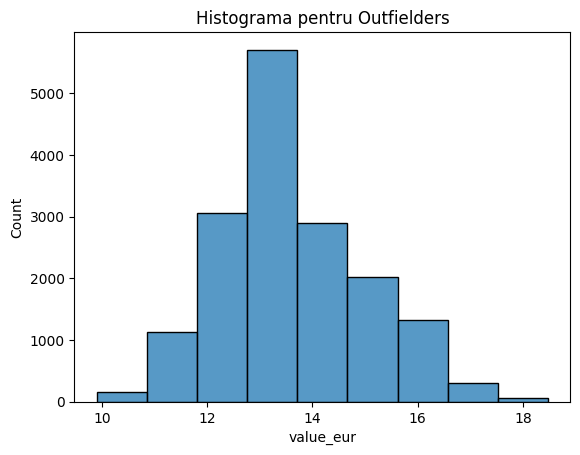

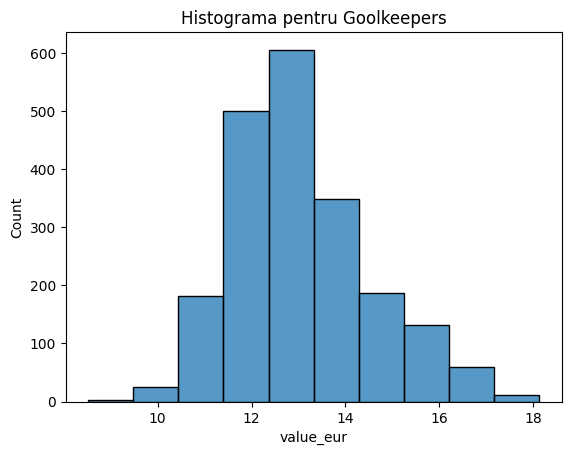

<Figure size 640x480 with 0 Axes>

In [104]:
sns.histplot(data=fifa_OUT ,x='value_eur',binwidth=1)
plt.title("Histograma pentru Outfielders")
plt.show()
plt.savefig("../outputs/plots/eda/Histograma_pentru_Outfielders_value_eur.png")
plt.clf()
sns.histplot(data=fifa_GK ,x='value_eur',binwidth=1,)
plt.title("Histograma pentru Goolkeepers")
plt.show()
plt.savefig("../outputs/plots/eda/Histograma_pentru_gk_value_eur.png")
plt.clf()

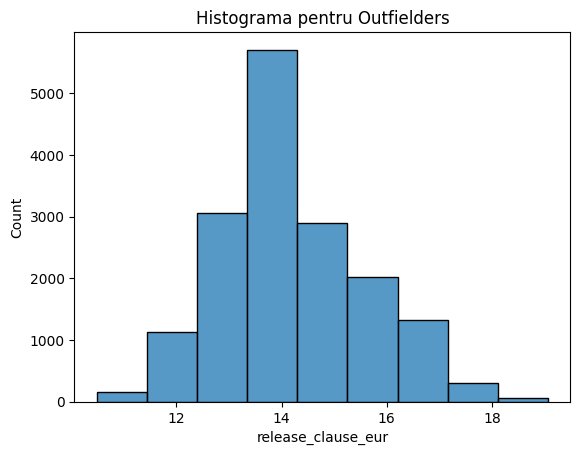

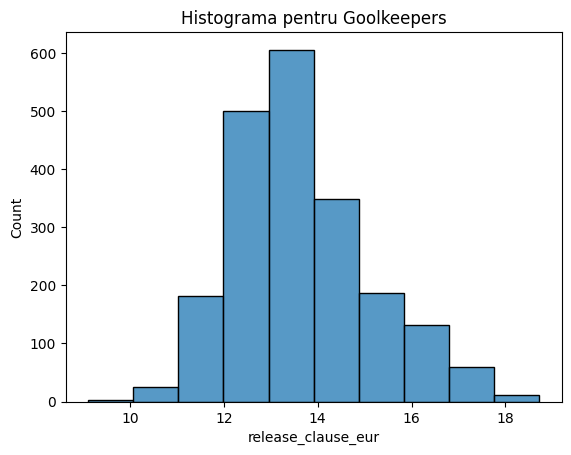

<Figure size 640x480 with 0 Axes>

In [105]:
sns.histplot(data=fifa_OUT ,x='release_clause_eur',binwidth=1)
plt.title("Histograma pentru Outfielders")
plt.show()
plt.savefig("../outputs/plots/eda/Histograma_pentru_Outfielders.png")
plt.clf()
sns.histplot(data=fifa_GK ,x='release_clause_eur',binwidth=1)
plt.title("Histograma pentru Goolkeepers")
plt.show()
plt.savefig("../outputs/plots/eda/Histograma_pentru_Gk.png")
plt.clf()

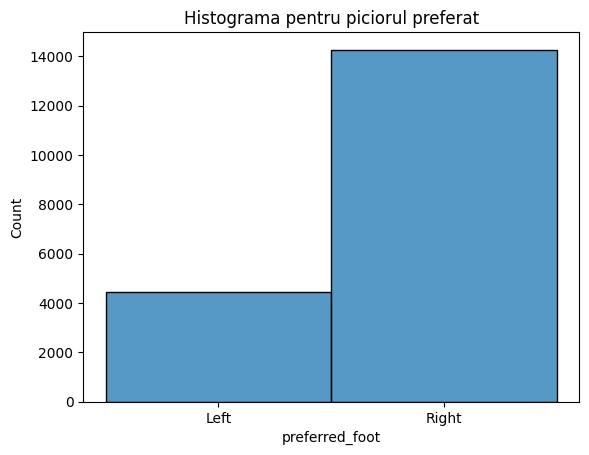

<Figure size 640x480 with 0 Axes>

In [106]:
sns.histplot(data=fifa ,x='preferred_foot',binwidth=1)
plt.title("Histograma pentru piciorul preferat")
plt.show()
plt.savefig("../outputs/plots/eda/Histograma_pentru_Piciorul_Preferat.png")
plt.clf()


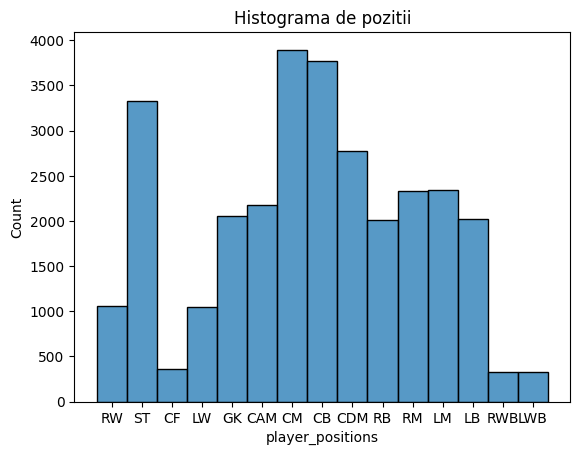

<Figure size 640x480 with 0 Axes>

In [107]:
all_positions = fifa['player_positions'].str.split(', ').explode()


sns.histplot(all_positions, discrete=True)
plt.title("Histograma de pozitii")
plt.show()
plt.savefig("../outputs/plots/eda/Histograma_pentru_Pozitii.png")
plt.clf()


C:\Users\lukas\AppData\Local\Temp\ipykernel_27020\2396129499.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_players, x='overall', y='short_name', palette='viridis')


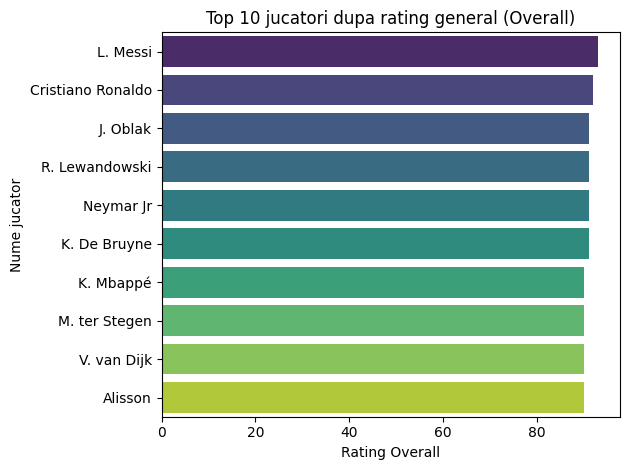

In [108]:
top_players = fifa[['short_name', 'overall']].sort_values(by='overall', ascending=False).head(10)
plt.figure()
sns.barplot(data=top_players, x='overall', y='short_name', palette='viridis')
plt.title('Top 10 jucatori dupa rating general (Overall)')
plt.xlabel('Rating Overall')
plt.ylabel('Nume jucator')
plt.tight_layout()
plt.savefig("../outputs/plots/eda/Top_10_Jucatori_dupa_Overall.png")
plt.show()

C:\Users\lukas\AppData\Local\Temp\ipykernel_27020\2730393761.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_nationalities.values, y=top_nationalities.index, palette='mako')


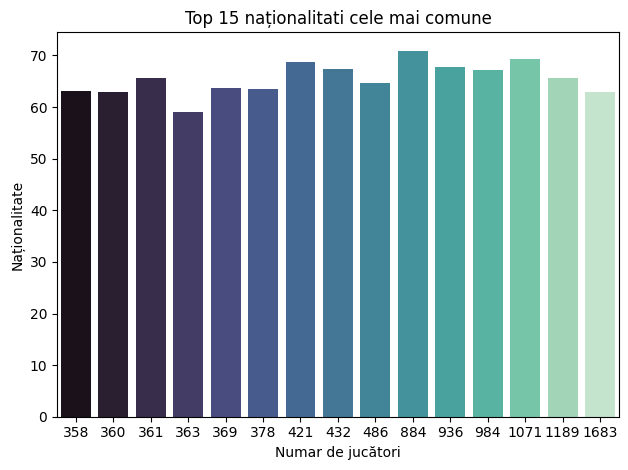

In [109]:
top_nationalities = fifa['nationality'].value_counts().head(15)
plt.figure()
sns.barplot(x=top_nationalities.values, y=top_nationalities.index, palette='mako')
plt.title('Top 15 naționalitati cele mai comune')
plt.xlabel('Numar de jucători')
plt.ylabel('Naționalitate')
plt.tight_layout()
plt.savefig("../outputs/plots/eda/Top_15_Nationalitati.png")
plt.show()

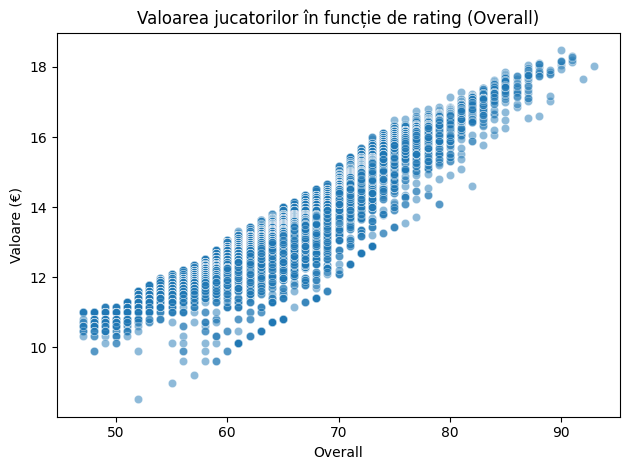

In [110]:
plt.figure()
sns.scatterplot(data=fifa, x='overall', y='value_eur', alpha=0.5)
plt.title('Valoarea jucatorilor în funcție de rating (Overall)')
plt.xlabel('Overall')
plt.ylabel('Valoare (€)')
plt.tight_layout()
plt.savefig("../outputs/plots/eda/Overall_vs_Valoare.png")
plt.show()

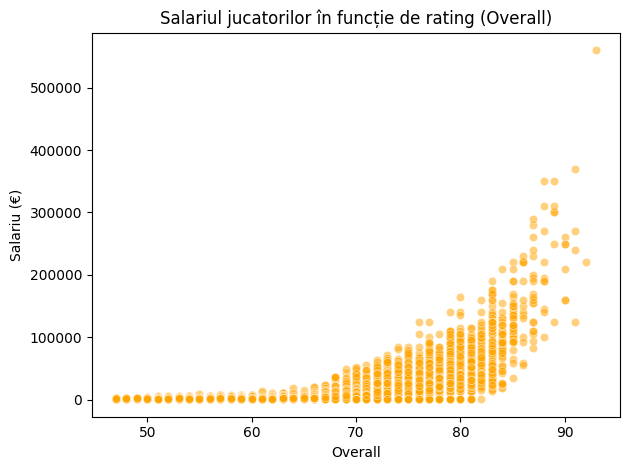

In [111]:
plt.figure()
sns.scatterplot(data=fifa, x='overall', y='wage_eur', alpha=0.5, color='orange')
plt.title('Salariul jucatorilor în funcție de rating (Overall)')
plt.xlabel('Overall')
plt.ylabel('Salariu (€)')
plt.tight_layout()
plt.savefig("../outputs/plots/eda/Overall_vs_Salariu.png")
plt.show()

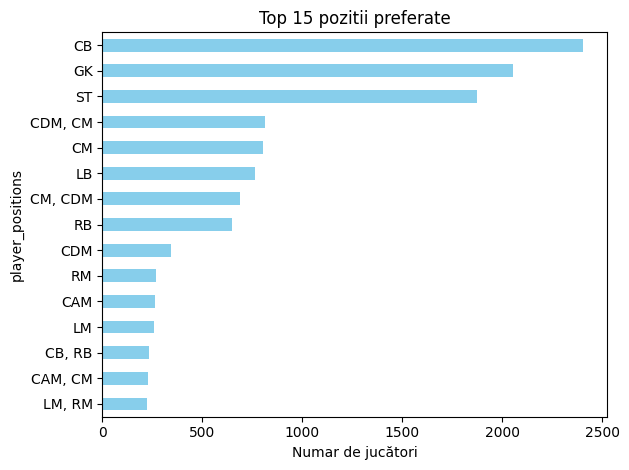

In [112]:
plt.figure()
fifa['player_positions'].value_counts().head(15).plot(kind='barh', color='skyblue')
plt.title('Top 15 pozitii preferate')
plt.xlabel('Numar de jucători')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("../outputs/plots/eda/Histograma_Pozitii.png")
plt.show()

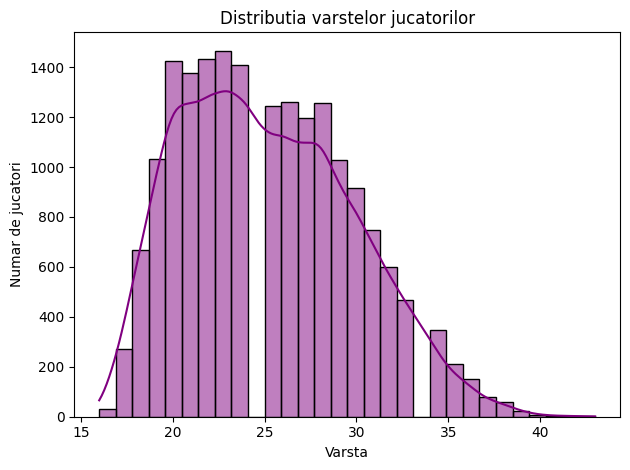

In [113]:
plt.figure()
sns.histplot(fifa['age'], bins=30, kde=True, color='purple')
plt.title('Distributia varstelor jucatorilor')
plt.xlabel('Varsta')
plt.ylabel('Numar de jucatori')
plt.tight_layout()
plt.savefig("../outputs/plots/eda/Distributia_Varstelor.png")
plt.show()

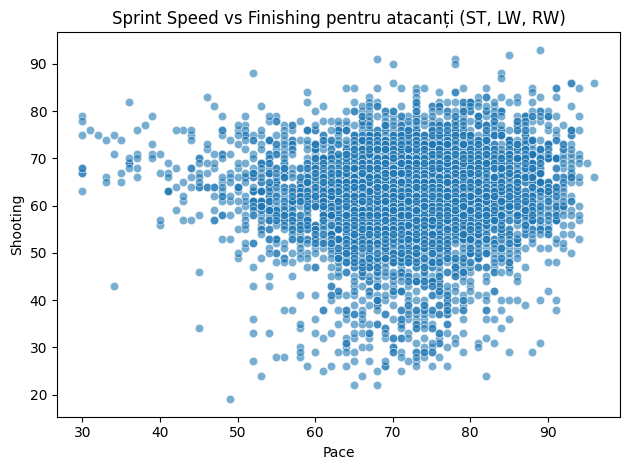

In [114]:
attackers = fifa[fifa['player_positions'].str.contains('ST|LW|RW', na=False)]
plt.figure()
sns.scatterplot(data=attackers, x='pace', y='shooting', alpha=0.6)
plt.title('Sprint Speed vs Finishing pentru atacanți (ST, LW, RW)')
plt.xlabel('Pace')
plt.ylabel('Shooting')
plt.tight_layout()
plt.savefig("../outputs/plots/eda/Sprint_vs_Finishing_Atacanti.png")
plt.show()

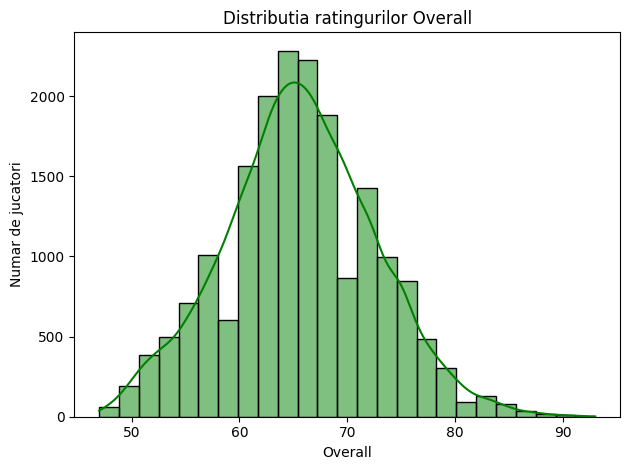

In [115]:
plt.figure()
sns.histplot(fifa['overall'], bins=25, kde=True, color='green')
plt.title('Distributia ratingurilor Overall')
plt.xlabel('Overall')
plt.ylabel('Numar de jucatori')
plt.tight_layout()
plt.savefig("../outputs/plots/eda/Distributia_Overall.png")
plt.show()


C:\Users\lukas\AppData\Local\Temp\ipykernel_27020\600901139.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_clubs.values, y=top_clubs.index, palette='coolwarm')


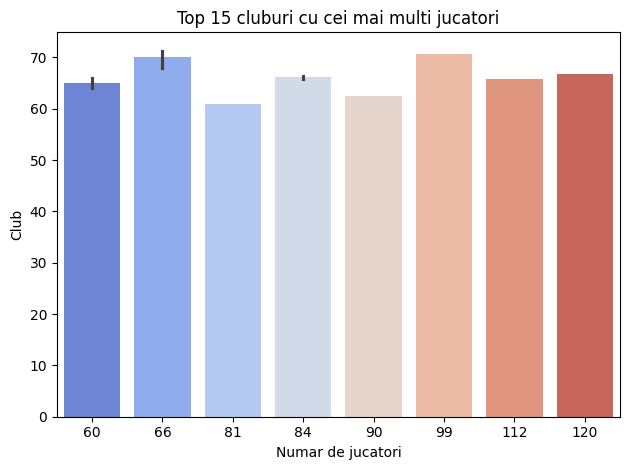

In [116]:
top_clubs = fifa['club_name'].value_counts().head(15)
plt.figure()
sns.barplot(x=top_clubs.values, y=top_clubs.index, palette='coolwarm')
plt.title('Top 15 cluburi cu cei mai multi jucatori')
plt.xlabel('Numar de jucatori')
plt.ylabel('Club')
plt.tight_layout()
plt.savefig("../outputs/plots/eda/Top_15_Cluburi_Jucatori.png")
plt.show()


C:\Users\lukas\AppData\Local\Temp\ipykernel_27020\2455852859.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_wage.values, y=avg_wage.index, palette='Blues_d')


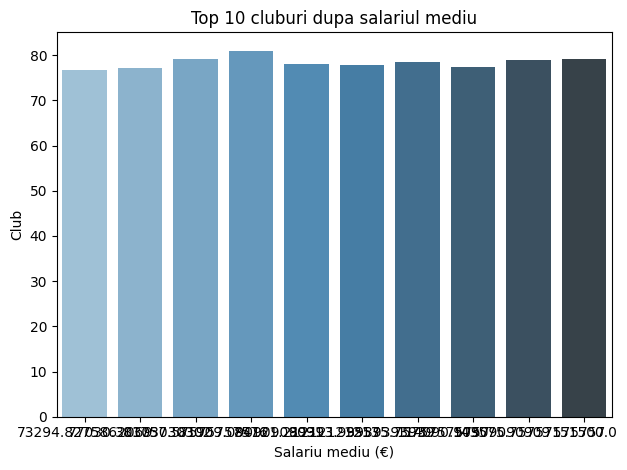

In [117]:
avg_wage = fifa.groupby('club_name')['wage_eur'].mean().sort_values(ascending=False).head(10)
plt.figure()
sns.barplot(x=avg_wage.values, y=avg_wage.index, palette='Blues_d')
plt.title('Top 10 cluburi dupa salariul mediu')
plt.xlabel('Salariu mediu (€)')
plt.ylabel('Club')
plt.tight_layout()
plt.savefig("../outputs/plots/eda/Top_10_Cluburi_Salariu_Mediu.png")
plt.show()


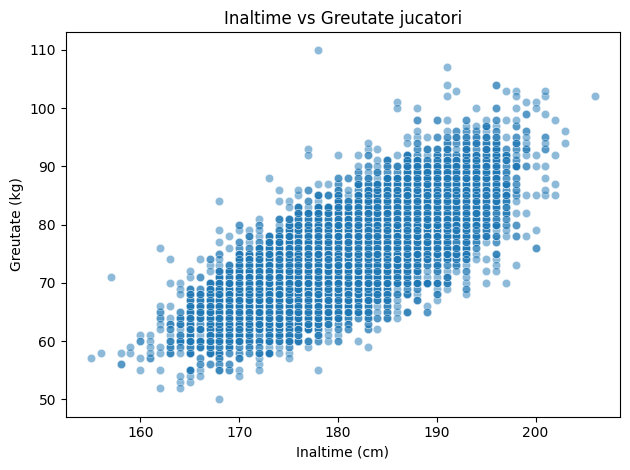

In [118]:
plt.figure()
sns.scatterplot(data=fifa, x='height_cm', y='weight_kg', alpha=0.5)
plt.title('Inaltime vs Greutate jucatori')
plt.xlabel('Inaltime (cm)')
plt.ylabel('Greutate (kg)')
plt.tight_layout()
plt.savefig("../outputs/plots/eda/Inaltime_vs_Greutate.png")
plt.show()


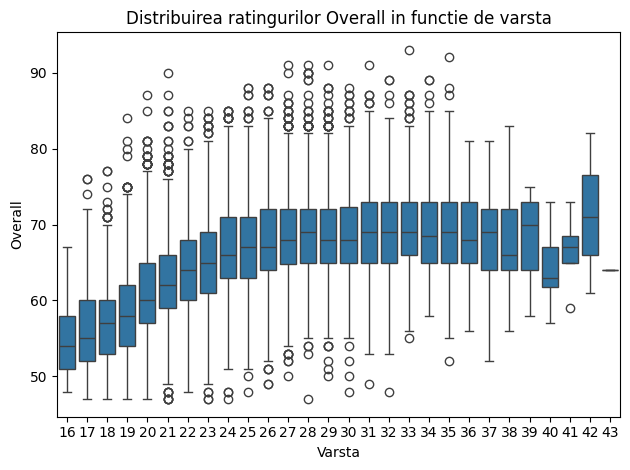

In [119]:
plt.figure()
sns.boxplot(data=fifa, x='age', y='overall')
plt.title('Distribuirea ratingurilor Overall in functie de varsta')
plt.xlabel('Varsta')
plt.ylabel('Overall')
plt.tight_layout()
plt.savefig("../outputs/plots/eda/Boxplot_Overall_vs_Varsta.png")
plt.show()


C:\Users\lukas\AppData\Local\Temp\ipykernel_27020\2389616535.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_wage_nat.values, y=top_wage_nat.index, palette='copper')


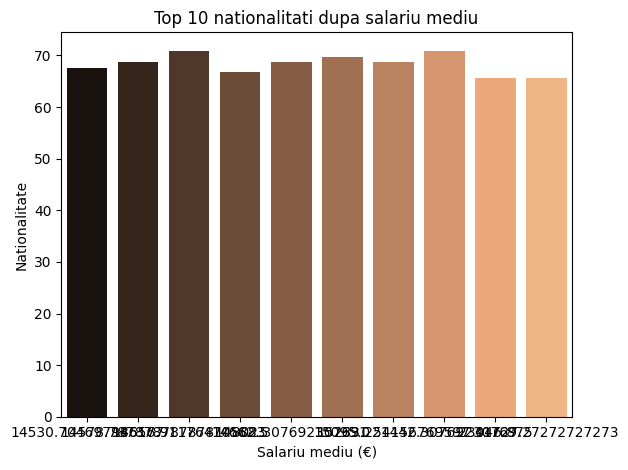

In [120]:
top_wage_nat = fifa.groupby('nationality')['wage_eur'].mean().sort_values(ascending=False).head(10)
plt.figure()
sns.barplot(x=top_wage_nat.values, y=top_wage_nat.index, palette='copper')
plt.title('Top 10 nationalitati dupa salariu mediu')
plt.xlabel('Salariu mediu (€)')
plt.ylabel('Nationalitate')
plt.tight_layout()
plt.savefig("../outputs/plots/eda/Top_10_Nationalitati_Salariu_Mediu.png")
plt.show()


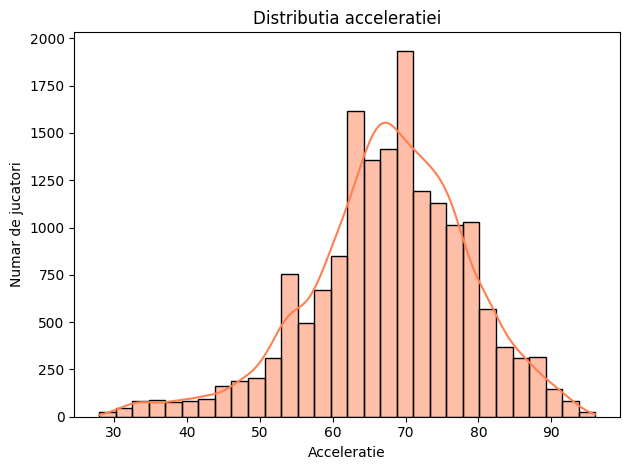

In [121]:
plt.figure()
sns.histplot(fifa['pace'], bins=30, kde=True, color='coral')
plt.title('Distributia acceleratiei')
plt.xlabel('Acceleratie')
plt.ylabel('Numar de jucatori')
plt.tight_layout()
plt.savefig("../outputs/plots/eda/Distributia_Acceleratie.png")
plt.show()


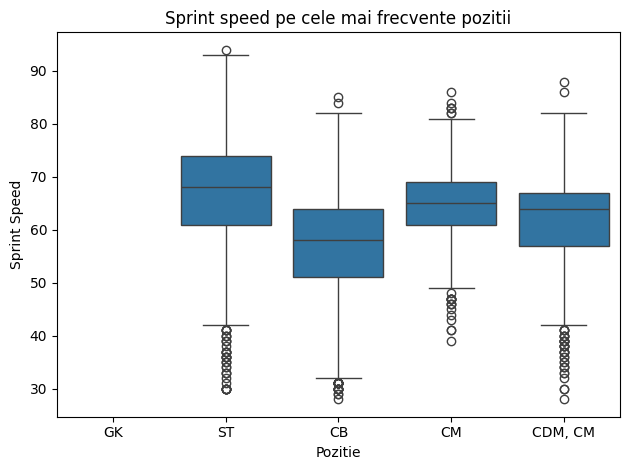

In [122]:
frequent_positions = fifa['player_positions'].value_counts().index[:5]
subset = fifa[fifa['player_positions'].isin(frequent_positions)]
plt.figure()
sns.boxplot(data=subset, x='player_positions', y='pace')
plt.title('Sprint speed pe cele mai frecvente pozitii')
plt.xlabel('Pozitie')
plt.ylabel('Sprint Speed')
plt.tight_layout()
plt.savefig("../outputs/plots/eda/SprintSpeed_pe_Pozitii.png")
plt.show()


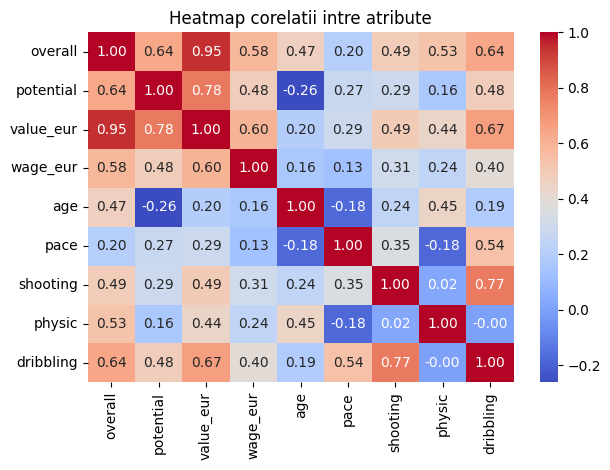

In [123]:
cols = ['overall', 'potential', 'value_eur', 'wage_eur', 'age', 'pace', 'shooting', 'physic', 'dribbling']
corr = fifa[cols].corr()
plt.figure()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap corelatii intre atribute')
plt.tight_layout()
plt.savefig("../outputs/plots/eda/Heatmap_Corelatii_Atribute.png")
plt.show()


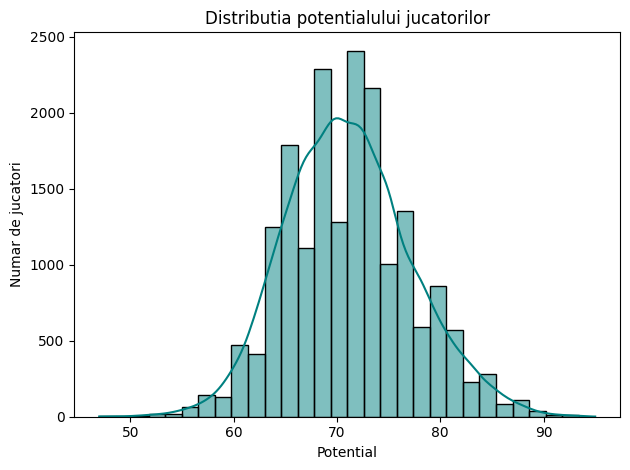

In [124]:
plt.figure()
sns.histplot(fifa['potential'], bins=30, kde=True, color='teal')
plt.title('Distributia potentialului jucatorilor')
plt.xlabel('Potential')
plt.ylabel('Numar de jucatori')
plt.tight_layout()
plt.savefig("../outputs/plots/eda/Distributia_Potentialului.png")
plt.show()


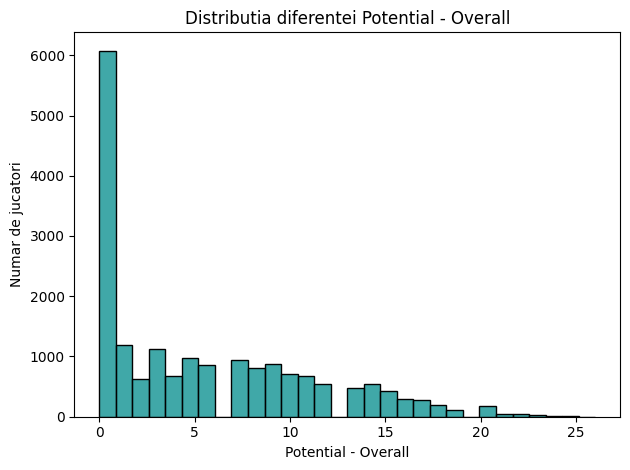

In [125]:
fifa['gap'] = fifa['potential'] - fifa['overall']
plt.figure()
sns.histplot(fifa['gap'], bins=30, color='darkcyan')
plt.title('Distributia diferentei Potential - Overall')
plt.xlabel('Potential - Overall')
plt.ylabel('Numar de jucatori')
plt.tight_layout()
plt.savefig("../outputs/plots/eda/Diferenta_Potential_vs_Overall.png")
plt.show()


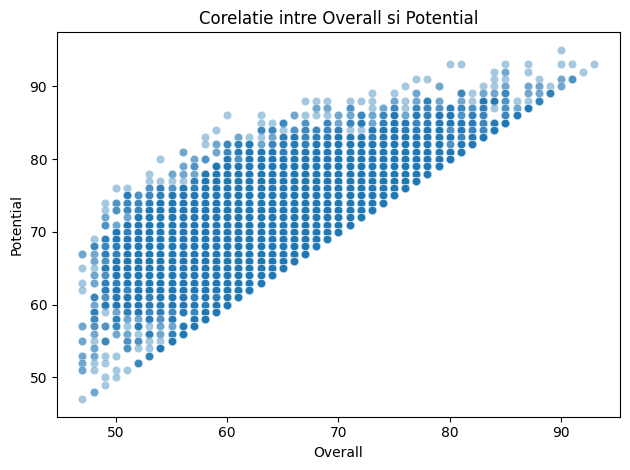

In [126]:
plt.figure()
sns.scatterplot(data=fifa, x='overall', y='potential', alpha=0.4)
plt.title('Corelatie intre Overall si Potential')
plt.xlabel('Overall')
plt.ylabel('Potential')
plt.tight_layout()
plt.savefig("../outputs/plots/eda/Scatter_Overall_vs_Potential.png")
plt.show()


In [ ]:
mififaielders = fifa[fifa['player_positions'].str.contains('CM|CAM|CDM', na=False)]
plt.figure()
sns.scatterplot(data=mififaielders, x='dribbling', y='passing', alpha=0.5)
plt.title('Dribbling vs  Passing pentru mijlocasi')
plt.xlabel('Dribbling')
plt.ylabel('Short Passing')
plt.tight_layout()
plt.savefig("../outputs/plots/eda/Dribbling_vs_Passing_Mijlocasi.png")
plt.show()


ValueError: Could not interpret value `short_passing` for `y`. An entry with this name does not appear in `data`.

<Figure size 640x480 with 0 Axes>

In [ ]:
pos_overall = fifa.groupby('player_positions')['overall'].mean().sort_values(ascending=False).head(10)
plt.figure()
sns.barplot(x=pos_overall.values, y=pos_overall.index, palette='plasma')
plt.title('Overall mediu pe pozitie (Top 10)')
plt.xlabel('Overall mediu')
plt.ylabel('Pozitie')
plt.tight_layout()
plt.savefig("../outputs/plots/eda/Overall_Mediu_pe_Pozitie.png")
plt.show()


In [ ]:
fifa['num_positions'] = fifa['player_positions'].apply(lambda x: len(str(x).split(',')))
plt.figure()
sns.countplot(x='num_positions', data=fifa, color='slateblue')
plt.title('Numar de pozitii pe care joaca fiecare jucator')
plt.xlabel('Numar pozitii')
plt.ylabel('Numar de jucatori')
plt.tight_layout()
plt.savefig("../outputs/plots/eda/Numar_Pozitii_per_Jucator.png")
plt.show()
